#### part 5 makemore - Wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [47]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [48]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a
......ma --> r
.....mar --> k
....mark --> u
...marku --> s
..markus --> .


In [ ]:
# pytorchifing the code yayayayaya

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self): 
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -------------------

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    # Input: (N, C) or (N, C, L), where N is the batch size, C is the number of features or channels, and L is the sequence length
    # Output: (N, C) or (N, C, L) (same shape as input)
    # Our BatchNorm1d is N, L, C, meaning C always last dim, so 
    # In official Torch BatchNorm1d, the input is (N, C, L) and ours is (N, L, C)
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -------------------
  
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -------------------

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
  
# -------------------

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters from all layers and stretch them out into a single list
        return [param for layer in self.layers for param in layer.parameters()]


In [118]:
torch.manual_seed(42); # seed rng for reproducibility

<img src="images/waves_net.png" width="800">

In [127]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [129]:
ix = torch.randint(0, Xtr.shape[0], (32,)) #lets look at the batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([32, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 10, 21, 14],
        [ 0,  0,  0,  0,  2, 21, 18,  1],
        [ 0,  0,  0, 19,  8,  1, 23, 14],
        [ 0,  0,  0, 19, 16, 18, 21,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 19,  1],
        [ 0,  0,  0,  0,  0,  1, 25,  8],
        [ 0,  0,  0, 11,  9, 14, 26, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 13,  1, 26,  5, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0, 19,  8],
        [ 0,  0,  0,  0,  0,  1, 25, 13],
        [ 0,  0,  0,  0,  5, 12, 12,  1],
        [ 0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  0, 20, 18,  9, 19, 20],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  1, 18, 13,  1],
        [ 1, 14, 20,  8, 15, 14,  

In [130]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [126]:
print(model.layers[3].running_mean.shape)

torch.Size([1, 1, 68])


#### Let's fix batchnorm bug here

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) # by setting (0,1) we calculate mean by 2 dimensions and get 1, 1, 68 instead of 1, 4,  68
evar = e.var((0,1), keepdim=True) # by setting (0,1) we calculate var by 2 dimensions and get 1, 1, 68  1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68 normalize to unit variance
print(ehat.shape)
print(emean.shape)


torch.Size([32, 4, 68])
torch.Size([1, 1, 68])
torch.Size([1, 4, 68])


In [101]:
logits.shape

torch.Size([4, 27])

In [102]:
model.layers[0].out.shape # output of the embedding layer

torch.Size([4, 8, 10])

In [103]:
model.layers[1].out.shape # output of the flatten layer

torch.Size([4, 4, 20])

In [104]:
model.layers[2].out.shape # output of the first linear layer

torch.Size([4, 4, 68])

In [105]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200)  + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [ ]:
#  (1 2) (3 4) (5 6) (7 8)
list(range(10))[1::2] # starts from 1 and gives every second element  [1, 3, 5, 7, 9]
list(range(10))[::2] # starts from 0 and gives every second element  [0, 2, 4, 6, 8]

[1, 3, 5, 7, 9]

In [79]:
e = torch.randn(4,8,10) # goal want this to be  (4, 4, 20) where consecutive 10d vectors are concatenated
explicit = torch.cat([e[:,::2, :], e[:,1::2, :]], dim=2) # concatenate along the last dimension (4, 4, 10) and (4,4,10) -> (4, 4, 20)
print(explicit.shape)

torch.Size([4, 4, 20])


In [81]:
(e.view(4,4,20) == explicit).all() # same thing as above but using view

tensor(True)

In [131]:
# same optimization last time 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # take random 32 examples to use in training
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    # emb = C[Xb] # [32,3,10] - embed characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
    logits = model(Xb) # forward pass
    loss = F.cross_entropy(logits, Yb) #  loss function 
    
    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # AFTER DEBUG would take out retain grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 1000:
    #     break  # After DEBUG would take out obviously to run full optimisation 

      0/ 200000: 3.2965
  10000/ 200000: 2.1871
  20000/ 200000: 1.9245
  30000/ 200000: 2.0503
  40000/ 200000: 2.2806
  50000/ 200000: 2.2586
  60000/ 200000: 2.1609
  70000/ 200000: 2.0563
  80000/ 200000: 1.9508
  90000/ 200000: 2.0375
 100000/ 200000: 2.0458
 110000/ 200000: 1.3223
 120000/ 200000: 1.7299
 130000/ 200000: 2.1027
 140000/ 200000: 1.9527
 150000/ 200000: 1.7263
 160000/ 200000: 1.9487
 170000/ 200000: 1.7910
 180000/ 200000: 1.6404
 190000/ 200000: 1.7060


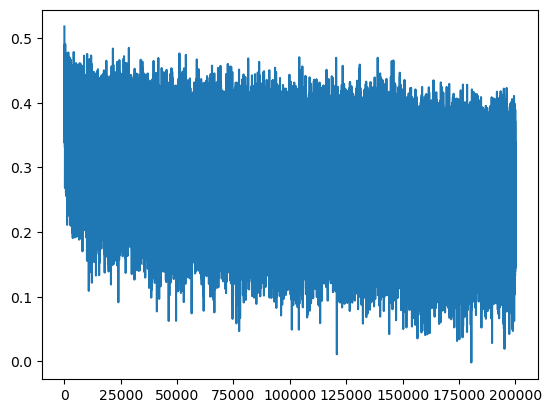

In [132]:
plt.plot(lossi)

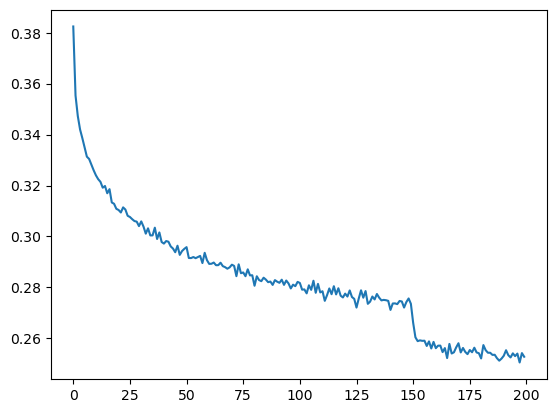

In [133]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [134]:
# put layers in eval mode (needed for batchnorm especially)
for layer in model.layers:
    if hasattr(layer, 'running_mean'):
        layer.training = False

In [135]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7686203718185425
val 1.988585352897644


#### perfomance log
* 3 symbol context (200 hidden, 12k params) train 2.058222770690918 val 2.1158394813537598
* 8 symbol context (22k params) train 1.921154260635376 val 2.025261163711548
* flat -> hierarchical (22k params) train 1.9421131610870361 val 2.022244691848755
* fix bug in batchnorm (22k params) train 1.9114701747894287 val 2.017404556274414
* scale up network to n_embd=24, n_hidden=128 (76k params) train 1.7686203718185425 val 1.988585352897644

In [58]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context])) # (1,block_size) -> (1,vocab_size)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

odhi.
aniyar.
gacy.
denasio.
mavenny.
dony.
damarione.
halleytindre.
bratymime.
noy.
aalianna.
marvo.
riskello.
shamei.
annalise.
clavaaia.
caylah.
davier.
jahlina.
luciano.


## Next time:
Why Convolutions? Brief preview/hint

In [141]:
for x,y in zip(Xtr[0:8], Ytr[0:8]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .


In [142]:
# forward pass a single example
logits = model(Xtr[[0]])
logits.shape

torch.Size([1, 27])

In [143]:
# forward all of them 
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolutions is "for loop"
# allows us to forward Linear Layers efficiently over space
class Conv1d:
  
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    self.weight = torch.randn((out_channels, in_channels, kernel_size)) * (2/(in_channels+out_channels))**0.5
    self.bias = torch.zeros(out_channels)
    self.stride = stride
    self.padding = padding
    
  def __call__(self, x):
    self.x = x
    # Unfold the input tensor to get sliding windows
    x_unfolded = x.unfoald(2, self.weight.shape[2], self.stride).contiguous()
    B, C, L, K = x_unfolded.shape
    x_unfolded = x_unfolded.view(B, C, L, K).permute(0, 2, 1, 3)
    
    # Perform the convolution manually
    self.out = torch.einsum('bijk,ojk->bio', x_unfolded, self.weight) + self.bias[None, :, None]
    return self.out
  
  def parameters(self):
    return [self.weight, self.bias]

class CasualDilutedConv1d:
  
  def __init__(self, in_channels, out_channels, kernel_size, dilation):
    self.weight = torch.randn((out_channels, in_channels, kernel_size)) * (2/(in_channels+out_channels))**0.5
    self.bias = torch.zeros(out_channels)
    self.dilation = dilation
    
  def __call__(self, x):
    self.x = x
    self.out = F.conv1d(x, self.weight, self.bias, padding=self.dilation, dilation=self.dilation)
    return self.out
  
  def parameters(self):
    return [self.weight, self.bias]

In [ ]:
import torch
import torch.nn
import torch.nn.functional as F

N =4, 
M = 3
#Embedding : (32, 8, 24)
x = torch.tensor([1,2,3,4])
w = torch.tensor([1,1,1])
stride = 1
padding = 1
size_out = (x.shape[0] - w.shape[0] + 2 * padding)//stride + 1
pad = torch.zeros(padding, dtype=x.dtype)
x = torch.cat([pad, x, pad])
y = torch.zeros(size_out)
for i in range(size_out):
  start = i * stride
  end = start + w.shape[0]  
  y[i] = x[start:end] @ w
y

tensor([3., 6., 9., 7.])

In [27]:
x = torch.tensor([1,2,3,4]).reshape(1, 4)
w = torch.tensor([1,1,1]).reshape(1,1, 3)

# conv1d = torch.nn.Conv1d(1, 1, 3, bias=False)
y = torch.nn.functional.conv1d(x, w, padding=0)
print(y)
print(y.shape)


tensor([[6, 9]])
torch.Size([1, 2])


In [32]:
N =4, 
M = 3
x = torch.tensor([1,2,3,4]).reshape(1,1,4)
w = torch.tensor([1,1,1])
stride = 1
padding = 1
size_out = (x.shape[-1] - w.shape[0] + 2 * padding)//stride + 1
pad = torch.zeros((1,1,padding), dtype=x.dtype)
print(x.shape)
x = torch.cat([pad, x, pad], dim=2)
print(x.shape)
y = torch.zeros(1, 1, size_out)
print(y.shape)
batch_size, seq_length, size = x.shape
for b in range(batch_size):
  for l in range(seq_length):
    for i in range(size_out):
      start = i * stride
      end = start + w.shape[0]  
      y[b, l, i] = x[b, l, start:end] @ w

y

torch.Size([1, 1, 4])
torch.Size([1, 1, 6])
torch.Size([1, 1, 4])


tensor([[[3., 6., 9., 7.]]])

In [ ]:
for i in range(size_out):
    print(x[...,i:i+3])
print(x)
print(x.shape[:-1] + (size_out,))

tensor([[[0, 1, 2]]])
tensor([[[1, 2, 3]]])
tensor([[[2, 3, 4]]])
tensor([[[3, 4, 0]]])
tensor([[[0, 1, 2, 3, 4, 0]]])
torch.Size([1, 1, 4])


lets think how dilation would look like

In [54]:
x =  torch.tensor([1,2,3,4]).reshape(1, 1, 4)
w = torch.tensor([1,1,1]).reshape(1,1,3)
stride = 1
padding = 1
dilation = 2
size_out = (x.shape[-1] + 2 * padding - (w.shape[-1] - 1) * dilation  - 1)//stride + 1
pad = torch.zeros((1,1,padding), dtype=x.dtype)
x = torch.cat([pad, x, pad], dim=-1)
y = torch.zeros(1, 1, size_out)
batch_size, seq_length, size = x.shape
print(y.shape)
for b in range(batch_size):
  for l in range(seq_length):
    for i in range(size_out):
      start = i * stride
      end = start + dilation * (w.shape[-1] - 1) + 1
      print(x[b, l, start:end:dilation].shape)
      print(w.shape)
      y[b, l, i] = (x[b, l, start:end:dilation] * w).sum()
y

torch.Size([1, 1, 2])
torch.Size([3])
torch.Size([1, 1, 3])
torch.Size([3])
torch.Size([1, 1, 3])


tensor([[[6., 4.]]])

In [66]:
# Correct conv logic with different in_channels and out_channels
in_channels = 1
out_channels = 2
x =  torch.tensor([1,2,3,4]).reshape(1, in_channels, 4)
w = torch.tensor([[1,1,1], [1,0,1]]).reshape(out_channels,in_channels,3)
stride = 1
padding = 1
dilation = 2
batch_size, seq_length, size = x.shape

size_out = (x.shape[-1] + 2 * padding - (w.shape[-1] - 1) * dilation  - 1)//stride + 1
pad = torch.zeros((batch_size,in_channels,padding), dtype=x.dtype)
x = torch.cat([pad, x, pad], dim=-1)
y = torch.zeros(batch_size, out_channels, size_out)

print(y.shape)
print(x.shape)
for b in range(batch_size):
  for l in range(out_channels):
    for i in range(size_out):
      start = i * stride
      end = start + dilation * (w.shape[-1] - 1) + 1
      print(x[b, :, start:end:dilation].shape)
      print(w[l].shape)
      y[b, l, i] = (x[b, :, start:end:dilation] * w[l]).sum()
y

torch.Size([1, 2, 2])
torch.Size([1, 1, 6])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])


tensor([[[6., 4.],
         [4., 1.]]])

In [57]:
torch.randn(2,1,3)

tensor([[[ 0.4224, -1.1704,  0.4819]],

        [[ 0.2800,  0.9983,  0.8257]]])